In [1]:
# ------------------------------------------------------------
# 0.  fast lattice lookup  (idea #1)
# ------------------------------------------------------------
# LUT = torch.arange(N_STATES, device=DEVICE).view(M_MAX + 1, P_MAX + 1)

# ------------------------------------------------------------
# 1.  Gene-expression CRN  (unchanged)
# ------------------------------------------------------------
class GeneExpressionCRN:
    def __init__(self, k_r=0.3, k_p=0.2, g_r=0.4, g_p=0.1):
        self.k_r, self.k_p, self.g_r, self.g_p = k_r, k_p, g_r, g_p

    def Ap(self, m, p, pm):
        """Generator applied to probability of state (m,p)."""
        prev_m   = pm.get(m - 1, p)
        prev_p   = pm.get(m, p - 1)
        next_m   = pm.get(m + 1, p)
        next_p   = pm.get(m, p + 1)
        cur      = pm.get(m, p)

        inflow  = self.k_r*prev_m + self.k_p*prev_p + self.g_r*next_m + self.g_p*next_p
        outflow = (self.k_r + self.k_p + self.g_r + self.g_p) * cur
        return inflow - outflow


# ------------------------------------------------------------
# 2.  Time-to-probability network  pθ(t)
# ------------------------------------------------------------
import numpy as np, torch, math, itertools

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
M_MAX, P_MAX = 8, 8                                 # lattice size  (small demo)

def state_to_idx(m, p): return m*(P_MAX+1) + p
N_STATES = (M_MAX+1)*(P_MAX+1)


class PosEnc(torch.nn.Module):
    def __init__(self, n_freq=6):
        super().__init__()
        self.register_buffer("f", 2**torch.arange(n_freq).float()*math.pi)

    def forward(self, t):
        t = t.unsqueeze(-1)
        return torch.cat([torch.sin(t*self.f), torch.cos(t*self.f)], dim=-1)


class ProbNet(torch.nn.Module):
    def __init__(self, hidden=128, n_freq=6, device='cuda'):
        super().__init__()
        self.enc  = PosEnc(n_freq)
        self.fc   = torch.nn.Sequential(
            torch.nn.Linear(2*n_freq, hidden), torch.nn.Tanh(),
            torch.nn.Linear(hidden, N_STATES)
        )
        self.device = device
        self.to(device)

    def forward(self, t):
        z = self.enc(t)
        logits = self.fc(z)                  # [B, N]
        return torch.softmax(logits, dim=-1) # pθ


# ------------------------------------------------------------
# 3.  Tiny helper that `GeneExpressionCRN` expects
# ------------------------------------------------------------
class PMdict: # FSP like structure
    """Wrap the flat tensor pθ(b, N) as pm.get(m,p)."""
    def __init__(self, probs_row):
        self.row = probs_row                 # shape [N]  (grad-tracked)

    def get(self, m, p):
        if m < 0 or p < 0 or m > M_MAX or p > P_MAX:
            return torch.zeros((), device=self.row.device, dtype=self.row.dtype)
        return self.row[state_to_idx(m, p)]


# ------------------------------------------------------------
# 4-fast.  Physics-informed training on a *sparse* batch
# ------------------------------------------------------------
def train(
    crn, net,
    *,
    steps          = 30_000,
    batch_time     = 128,    # #different time-points per step
    states_per_t   = 8,      # #random (m,p) per time-point
    lr             = 3e-3,
    t_max          = 10.0,
    report_every   = 300,
):

    opt = torch.optim.Adam(net.parameters(), lr)

    # --- pre-compute neighbour offsets for vectorised Ap ---------------
    neigh = torch.tensor([[-1,  0], [1, 0],    # m-1, m+1
                          [ 0, -1], [0, 1]],   # p-1, p+1
                        device=DEVICE)

    k_r, k_p, g_r, g_p = crn.k_r, crn.k_p, crn.g_r, crn.g_p
    rates_in  = torch.tensor([k_r, g_r, k_p, g_p], device=DEVICE)   # inflow
    rate_out  = k_r + k_p + g_r + g_p

    for step in range(1, steps + 1):

        # ────────────────────────────────────────────────────────────
        # 1) sample times  & lattice indices (vectorised)
        # ────────────────────────────────────────────────────────────
        t  = torch.rand(batch_time, device=DEVICE, requires_grad=True) * t_max
        m  = torch.randint(0, M_MAX + 1, (batch_time, states_per_t), device=DEVICE)
        p  = torch.randint(0, P_MAX + 1, (batch_time, states_per_t), device=DEVICE)

        B, S = m.shape            # B=batch_time, S=states_per_t
        idx  = state_to_idx(m, p)  # [B,S]

        # ────────────────────────────────────────────────────────────
        # 2) forward pass – full probability *row*  (no loops)
        # ────────────────────────────────────────────────────────────
        probs = net(t)                         # [B, N_STATES]

        # gather p(m,p)
        p_mp = probs.gather(1, idx)            # [B, S]

        # ────────────────────────────────────────────────────────────
        # 3) d/dt p(m,p) via autograd.grad  (one call)
        # ────────────────────────────────────────────────────────────
        grad_mask = torch.zeros_like(probs)    # same shape [B,N]
        grad_mask.scatter_(1, idx, 1.0)        # ones at sampled states

        # gradient of  ∑ mask_i * p_i  gives sum of dp/dt at sampled entries
        dpdt_sum = torch.autograd.grad(
            outputs=(probs * grad_mask).sum(),
            inputs=t,
            create_graph=True
        )[0]                                   # [B]

        # expand to [B,S] by dividing by S (all masks are 1)
        dpdt = dpdt_sum[:, None].repeat(1, S) / S

        # ────────────────────────────────────────────────────────────
        # 4) vectorised Ap(m,p)  for the same samples
        # ────────────────────────────────────────────────────────────
        m_exp = m.unsqueeze(-1) + neigh[:, 0]  # [B,S,4]
        p_exp = p.unsqueeze(-1) + neigh[:, 1]

        valid = (m_exp >= 0) & (m_exp <= M_MAX) & (p_exp >= 0) & (p_exp <= P_MAX)
        idx_n = state_to_idx(
            m_exp.clamp(0, M_MAX),
            p_exp.clamp(0, P_MAX)
        )

        probs_exp  = probs.unsqueeze(1).expand(-1, S, -1)        # [B,S,N]
        neigh_vals = probs_exp.gather(2, idx_n).float()          # [B,S,4]
        neigh_vals *= valid.float()


        inflow = (neigh_vals * rates_in).sum(dim=-1)       # [B,S]
        outflow = rate_out * p_mp
        Ap_val = inflow - outflow                          # [B,S]

        # ────────────────────────────────────────────────────────────
        # 5) loss = residual + IC at t=0
        # ────────────────────────────────────────────────────────────
        res_loss = ((dpdt - Ap_val) ** 2 / (1e-6 + p_mp.detach())).mean()

        # check the probability of the sample
        reference = torch.zeros_like(probs)
        reference[:, 0] = 1.0  # initial condition: p(0,0) = 1.0
        ic_loss = ((probs - reference)**2).max(dim=1)[0].mean()  # max over all states

        loss = res_loss + ic_loss

        # ────────────────────────────────────────────────────────────
        opt.zero_grad(); loss.backward(); opt.step()
        # ────────────────────────────────────────────────────────────

        if step % report_every == 0 or step == 1:
            print(f"step {step:6d} | loss {loss.item():.3e} | res {res_loss.item():.3e} | ic {ic_loss.item():.3e} ")


# ------------------------------------------------------------
# 5.  Visual sanity check  p0,0(t) over time
# ------------------------------------------------------------
@torch.no_grad()
def plot_trajectory(net, m=0, p=0, t_max=10.0):
    import matplotlib.pyplot as plt
    ts = torch.linspace(0, t_max, 200, device=DEVICE)
    ps = []
    for t in ts:
        ps.append(net(t.unsqueeze(0))[0, state_to_idx(m,p)].item())
    plt.plot(ts.cpu(), ps)
    plt.xlabel("t"); plt.ylabel(f"p({m},{p})"); plt.title("probability of (m,p) over time")
    plt.show()


# ------------------------------------------------------------
# 6.  Run demo
# ------------------------------------------------------------
crn  = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2)
net  = ProbNet().to(DEVICE)
try:
    train(crn, net, steps=200000, states_per_t=1, lr=1e-4, batch_time=4096, t_max=1.5)
except KeyboardInterrupt:
    print("Training interrupted.")



step      1 | loss 2.288e+00 | res 1.312e+00 | ic 9.762e-01 
step    300 | loss 1.099e+00 | res 1.231e-01 | ic 9.757e-01 
step    600 | loss 1.054e+00 | res 7.875e-02 | ic 9.749e-01 
step    900 | loss 1.035e+00 | res 6.103e-02 | ic 9.741e-01 
step   1200 | loss 1.022e+00 | res 4.819e-02 | ic 9.734e-01 
step   1500 | loss 1.016e+00 | res 4.324e-02 | ic 9.732e-01 
step   1800 | loss 1.014e+00 | res 4.142e-02 | ic 9.728e-01 
step   2100 | loss 1.005e+00 | res 3.207e-02 | ic 9.727e-01 
step   2400 | loss 1.002e+00 | res 2.937e-02 | ic 9.722e-01 
step   2700 | loss 9.979e-01 | res 2.663e-02 | ic 9.713e-01 
step   3000 | loss 9.959e-01 | res 2.593e-02 | ic 9.700e-01 
step   3300 | loss 9.911e-01 | res 2.325e-02 | ic 9.679e-01 
step   3600 | loss 9.868e-01 | res 2.375e-02 | ic 9.630e-01 
step   3900 | loss 9.780e-01 | res 2.448e-02 | ic 9.536e-01 
step   4200 | loss 9.755e-01 | res 4.124e-02 | ic 9.342e-01 
step   4500 | loss 9.503e-01 | res 4.299e-02 | ic 9.073e-01 
step   4800 | loss 9.251

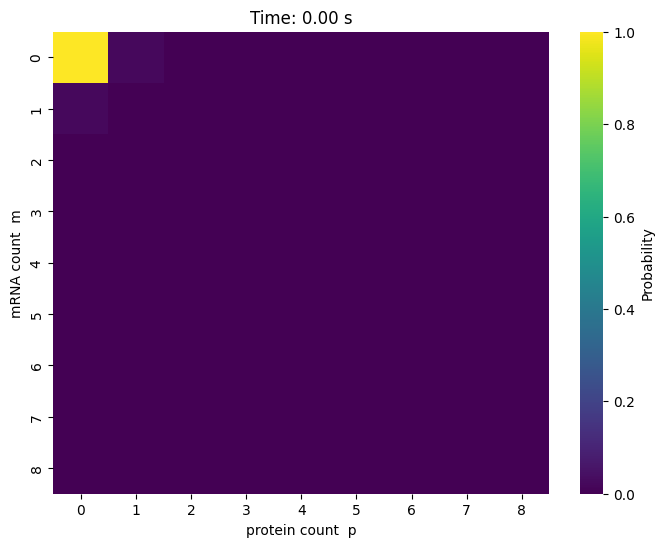

In [2]:
# ------------------------------------------------------------
# 6.  Single helper that can create *or* update a heat-map
# ------------------------------------------------------------
@torch.no_grad()
def plot_heatmap(net, t, ax=None, hm=None, title=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    # ---- evaluate model
    probs = (
        net(t.unsqueeze(0))[0]                       # [N_STATES]
        .cpu()
        .numpy()
        .reshape(M_MAX + 1, P_MAX + 1)
    )
    probs = probs / probs.max()

    # ---- first call: create figure + heat-map
    if hm is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        hm = sns.heatmap(
            probs,
            vmin=0.0, vmax=1.0,
            cmap="viridis",
            cbar_kws={'label': 'Probability'},
            ax=ax, annot=False
        )
        ax.set_xlabel("protein count  p")
        ax.set_ylabel("mRNA count  m")
    # ---- subsequent calls: update in place
    else:
        hm.collections[0].set_array(probs.ravel())

    if title is not None:
        ax.set_title(title)
    return ax, hm                           # always return the handles


# ------------------------------------------------------------
# updated animate_heatmap – returns the animation object
# ------------------------------------------------------------
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def animate_heatmap(net, t_max=10.0, num_frames=50):
    # first frame
    t0 = torch.tensor(0.0, device=DEVICE, dtype=torch.float32)
    ax, hm = plot_heatmap(net, t0, title="Time: 0.00 s")

    def update(frame):
        t_val = frame * t_max / (num_frames - 1)
        t_tensor = torch.tensor(t_val, device=DEVICE, dtype=torch.float32)
        plot_heatmap(
            net, t_tensor, ax=ax, hm=hm,
            title=f"Time: {t_val:.2f} s"
        )
        return hm.collections

    ani = animation.FuncAnimation(
        hm.figure, update,
        frames=num_frames, blit=False, repeat=True
    )
    return ani         # <-- keep a handle outside


# ------------------------------------------------------------
# Usage after training:
# ------------------------------------------------------------
ani = animate_heatmap(net, t_max=1.5, num_frames=50)
# save as GIF 
ani.save("gene_expression_crn.gif", writer='pillow', fps=10)
